In [46]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 285 kB 30 kB/s eta 0:00:011
     |████████████████████████████████| 27.2 MB 26 kB/s eta 0:00:017   |███                             | 2.5 MB 80 kB/s eta 0:05:06     |██████████▌                     | 9.0 MB 38 kB/s eta 0:08:00
You should consider upgrading via the '/python/bin/python3 -m pip install --upgrade pip' command.


In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

In [16]:
root_ds = 'dataset'
img_size_ori = 101

# Data Exploration

Let's look at some data. We can see that TGS chose to use very varied data by inspecting. That is great and adresses a problem in deep learning geoscience at the moment. We build models on one type of seismic and have no idea whether it generalizes.

In [109]:
def plot_mask_on_img(ax, img, mask, meta=None):
    mask = np.ma.masked_where( mask == 0, mask)
    ax.imshow(img, cmap="gray")
    ax.imshow(mask, alpha=0.5, cmap="jet")
    if meta is not None:
        ax.text(1, img_size_ori-1, meta.z, color="white")
        ax.text(img_size_ori - 1, 1, round(meta.coverage, 2), color="white", ha="right", va="top")
        ax.text(1, 1, meta.coverage_class, color="white", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])

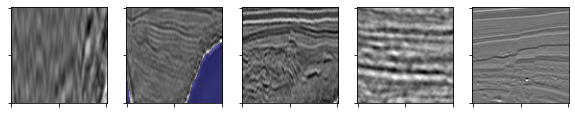

In [104]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
fig, axs = plt.subplots(1, len(ids), figsize=(10, 10))
for j, img_name in enumerate(ids):
    img = Image.open(os.path.join(root_ds, 'train/images/' + img_name + '.png'))
    img_mask = np.array(Image.open(os.path.join(root_ds, 'train/masks/' + img_name + '.png')), dtype=np.uint8)
    plot_mask_on_img(axs[j], img, img_mask)
plt.show()

## Load DF

In [4]:
train_df = pd.read_csv(os.path.join(root_ds, "train.csv"), index_col="id", usecols=[0])
depths_df = pd.read_csv(os.path.join(root_ds, "depths.csv"), index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [49]:
train_df["images"] = [np.array(Image.open(os.path.join(root_ds, "train/images/{}.png".format(idx))), dtype=np.uint8) / 255 for idx in tqdm(train_df.index)]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [50]:
train_df["masks"] = [np.array(Image.open(os.path.join(root_ds, "train/masks/{}.png".format(idx))), dtype=np.uint8) / 255 for idx in tqdm(train_df.index)]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [29]:
train_df["coverage"] = train_df.masks.map(lambda x: np.sum(x) / pow(img_size_ori, 2))

In [30]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0, 0.5, 'Coverage class')

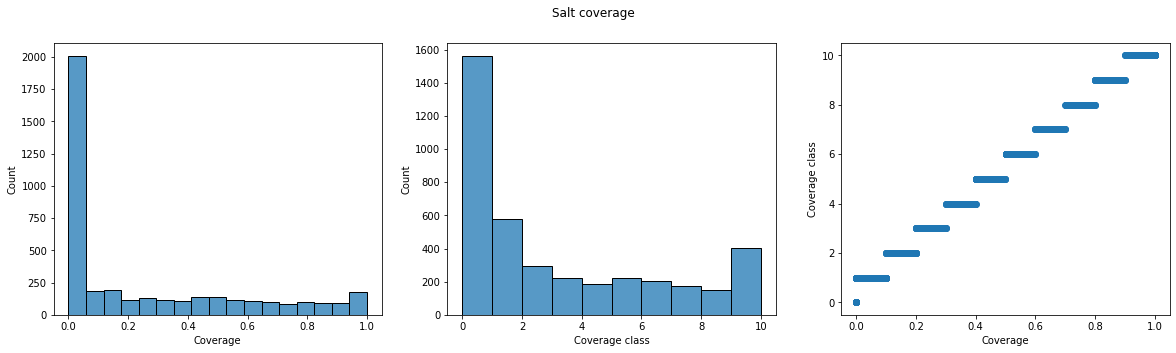

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
sns.histplot(train_df.coverage, kde=False, ax=axs[0])
sns.histplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")
axs[2].scatter(train_df.coverage, train_df.coverage_class)
axs[2].set_xlabel("Coverage")
axs[2].set_ylabel("Coverage class")

Text(0.5, 0.98, 'Depth distribution')

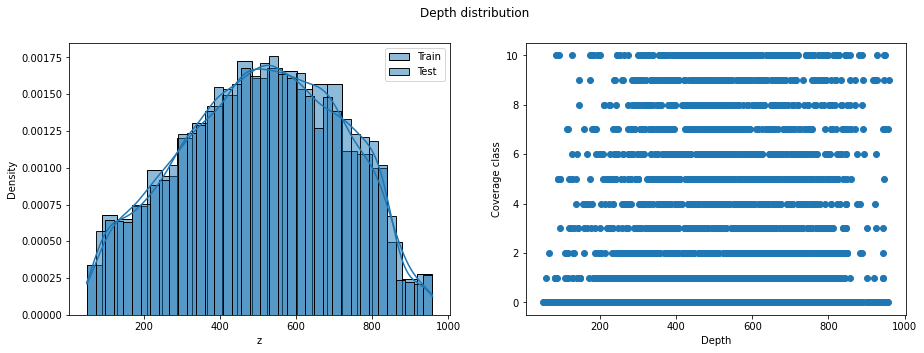

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(train_df.z, label="Train", kde=True, stat='density', ax=axs[0])
sns.histplot(test_df.z, label="Test", kde=True, stat='density', ax=axs[0])
axs[0].legend()

axs[1].scatter(train_df.z, train_df.coverage_class)
axs[1].set_xlabel("Depth")
axs[1].set_ylabel("Coverage class")

plt.suptitle("Depth distribution")

## Show some example images

In [52]:
train_df = train_df.sort_values('z').reset_index()

In [116]:
def plot_images(start, step, max_images=60):
    grid_width = 10
    grid_height = int(max_images / grid_width)
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))
    for i in range(max_images):
        idx = i * step + start
        img = train_df.loc[idx].images
        mask = train_df.loc[idx].masks
        ax = axs[int(i / grid_width), i % grid_width]
        plot_mask_on_img(ax, img, mask, train_df.loc[idx])
    plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

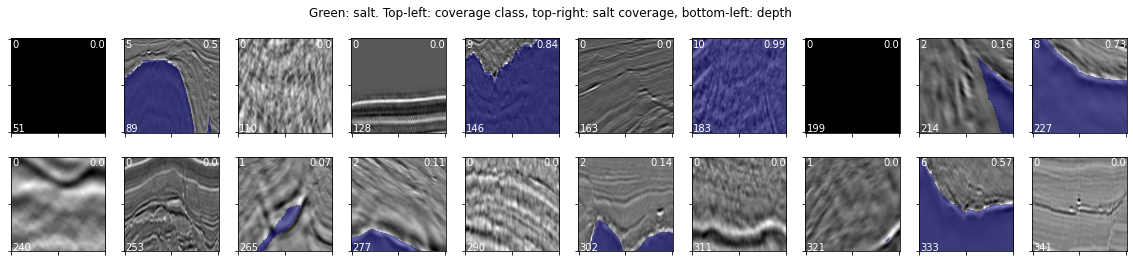

In [121]:
plot_images(0, 50, 20)

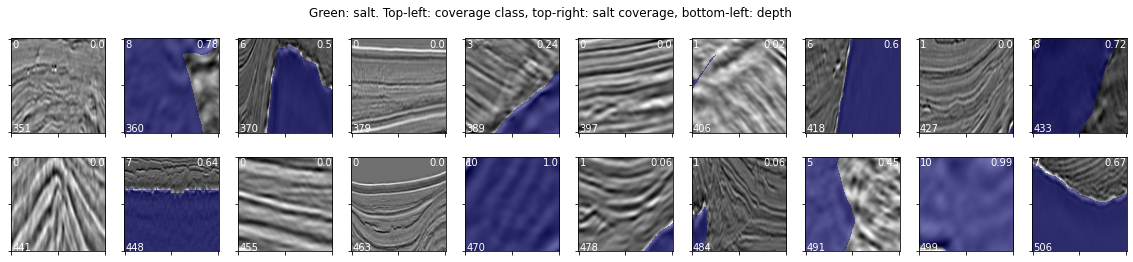

In [122]:
plot_images(1000, 50, 20)

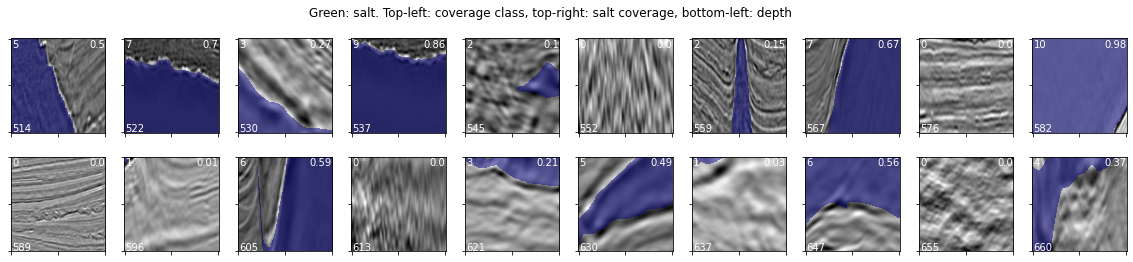

In [123]:
plot_images(2000, 50, 20)

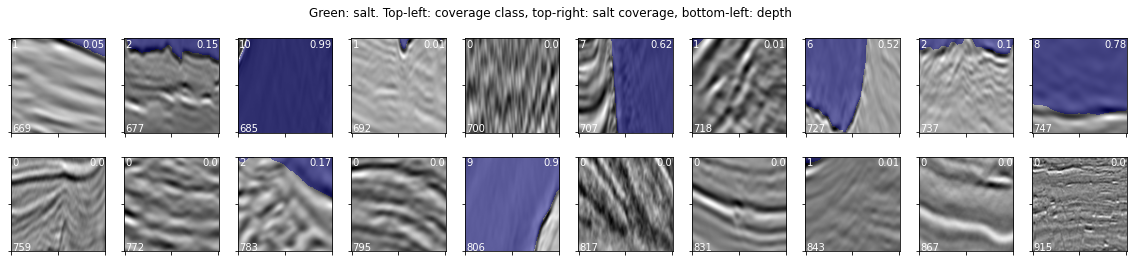

In [124]:
plot_images(3000, 50, 20)